## Spherical SLD models fitted to BULCH profiles

This notebook demonstrates how Cryo-EM data can be used to guide modeling of SANS data using SasView. 
The data is contrast variation SANS recorded for hepatisis B virus. 7 contrasts data sets have been decomposed to protein and RNA profiles using BULCH method (unpublished) and therefore here we will only consider two profiles. The outline of the workflow is shown in the picture bellow:  
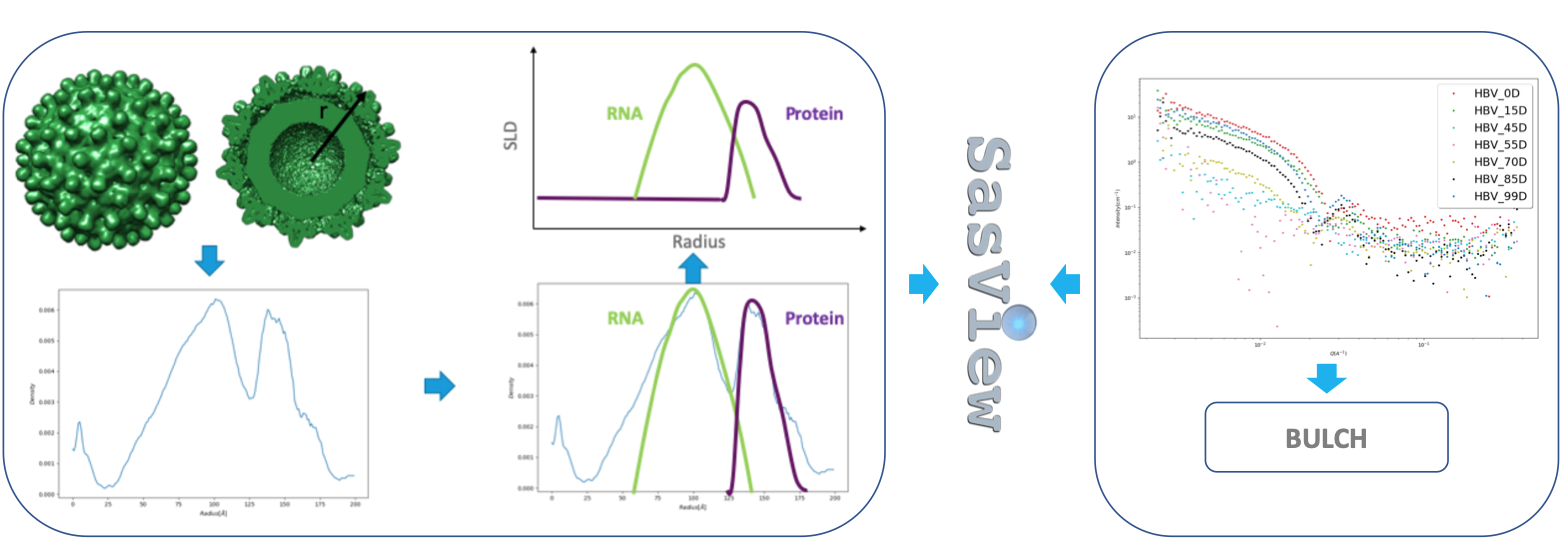

Radial profile is calculated from electron density and is subsequently used to genenerate corresponding SLD profile, which is turn applied to construct spherical SLD models in SasView. 

### Notebook outline:
* Load data 
* Set up models
* (Plot SLD profile) 
* Fitting

### Import sasmodels, bumps and matpolotlib

In [ ]:
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasdata.dataloader.loader import Loader

from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

import matplotlib
import matplotlib.pyplot as plt
from scipy.special import erf, expm1

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({"figure.autolayout" : True})

### Plotting functions

In [ ]:
SHAPE_FUNCTIONS = [
    lambda z, nu: erf(nu/sqrt(2)*(2*z-1))/(2*erf(nu/sqrt(2))) + 0.5,  # erf
    lambda z, nu: z**nu,                    # Rpow
    lambda z, nu: 1 - (1-z)**nu,            # Lpow
    lambda z, nu: expm1(-nu*z)/expm1(-nu),  # Rexp
    lambda z, nu: expm1(nu*z)/expm1(nu),    # Lexp
    lambda z, nu: 1 - (1 - z**2)**(0.5*nu-2.0), # Boucher    
]

In [ ]:
## From spherical SLD model. Worth trying to import 
def profile(n_shells, sld_solvent, sld, thickness,
            interface, shape, nu, n_steps):
    """
    Returns shape profile with x=radius, y=SLD.
    """

    n_shells = int(n_shells + 0.5)
    n_steps = int(n_steps + 0.5)
    z = []
    rho = []
    z_next = 0
    # two sld points for core
    z.append(z_next)
    rho.append(sld[0])

    for i in range(0, n_shells):
        z_next += thickness[i]
        z.append(z_next)
        rho.append(sld[i])
        dz = interface[i]/n_steps
        sld_l = sld[i]
        sld_r = sld[i+1] if i < n_shells-1 else sld_solvent
        fun = SHAPE_FUNCTIONS[int(np.clip(shape[i], 0, len(SHAPE_FUNCTIONS)-1))]
        for step in range(1, n_steps+1):
            portion = fun(float(step)/n_steps, max(abs(nu[i]), 1e-14))
            z_next += dz
            z.append(z_next)
            rho.append((sld_r - sld_l)*portion + sld_l)
    z.append(z_next*1.2)
    rho.append(sld_solvent)
    # return sld profile (r, beta)
    return np.asarray(z), np.asarray(rho)


In [ ]:
def make_intensity_plot(qvector, exp_intensities, sim_intensities, exp_errors):
    """
    Produces plot given the data
    :param data:
    :param log:
    :return:
    """
    #matplotlib.rcParams.update({'font.size': 18})
    
    plt.plot(qvector, sim_intensities, '-', markersize=4, zorder=5)
    plt.errorbar(qvector, exp_intensities, yerr=exp_errors,
                 fmt="ko", markersize=6, mfc='none', alpha=0.6, zorder=0)

    plt.yscale('log')
    plt.xscale('log')

    plt.ylabel("$Intenisty$")
    plt.xlabel("$q [\AA^{-1}]$")
    plt.show()

### Saving parameters to file 

In [ ]:
#Written as a single line
def parameters_string(sld_solvent, sld1, sld2, thickness1, interface1, thickness2, interface2):
    """
    Writting string that can be pased to sasview with update parameters
    """
    parameters = f'sasview_parameter_values:model_name,spherical_sld:scale,False,0.0004148,None,0.0,inf,()'
    parameters += f':background,False,0.0035231,None,-inf,inf,():sld_solvent,False,{sld_solvent},None,-inf,inf,()'
    parameters += f':n_steps,False,35,None,0.0,inf,():n_shells,None,1:sld1,False,{sld1},None,-inf,inf,()'
    parameters += f':thickness1,True,{thickness1},None,0.0,inf,():interface1,False,{interface1},None,0.0,inf,()'
    parameters += f':shape1,False,0,None,,,():nu1,False,2.5,None,1.0,inf,():sld2,False,{sld2},None,-inf,inf,()'
    parameters += f':thickness2,True,{thickness2},None,0.0,inf,():interface2,False,{interface2},None,0.0,inf,()'
    parameters += f':shape2,False,0,None,,,():nu2,False,2.5,None,1.0,inf,()'
    parameters += f':multiplicity,2:is_data,True:tab_index,1'
    #parameters += f':is_batch_fitting,False:data_name,[]:data_id,[]:tab_name,M1:q_range_min,0.00235:q_range_max,0.32849'
    #parameters += f':q_weighting,1:weighting,1:smearing,1:smearing_min,0.0:smearing_max,0.0:polydisperse_params,False'
    #parameters += f':magnetic_params,False:chainfit_params,False:2D_params,False:fitpage_category,Sphere:fitpage_model,spherical_sld'
    #parameters += f':fitpage_structure,None:'
    return parameters

### Protein parameters

In [ ]:
n_shells = 2
n_steps = 35.0
sld_solvent = 4.225
sld = [4.225, 2.81]
thickness = [110, 10]
interface = [20, 60]
shape = [0]*2
nu = [2.5]*2

In [ ]:
radius_protein, sld_protein = profile(n_shells, sld_solvent, sld, thickness,
            interface, shape, nu, n_steps)

### RNA parameters

In [ ]:
n_shells = 2
n_steps = 35.0
sld_solvent = 2.475
sld = [2.475, 3.96]
thickness = [40, 5]
interface = [20, 60]
shape = [0,3]
nu = [2.5]*2

In [ ]:
radius_rna, sld_rna = profile(n_shells, sld_solvent, sld, thickness,
            interface, shape, nu, n_steps)

In [ ]:
plt.plot(radius_protein, sld_protein, label='protein')
plt.plot(radius_rna, sld_rna, label='RNA')
plt.xlabel('radius [Å]')
plt.ylabel('SLD')
plt.legend()

### Loading data 

In [ ]:
loader = Loader()
protein_data = loader.load('notebook_files/i11_bulch_res.dat')[0]
rna_data = loader.load('notebook_files/i22_bulch_res.dat')[0]

protein_data.qmin = protein_data.xmin
protein_data.qmax = protein_data.xmax
protein_data.mask = np.isnan(protein_data.y)

rna_data.qmin = rna_data.xmin
rna_data.qmax = rna_data.xmax
rna_data.mask = np.isnan(rna_data.y)

### Defining model

In [ ]:
# Protein parameters
kernel = load_model('spherical_sld')
pars = dict(
    background = 0.0051792,
    scale = 0.00046804,
    n_shells = 2,
    n_steps = 35.0,
    sld_solvent = 4.225,
    sld1 = 4.225,
    sld2 = 2.81,
    thickness1 = 110,
    thickness2 = 10,
    interface1 = 20,
    interface2 = 60, 
    shape1 = 0,
    shape2 = 0,
    nu1 = 2.5,
    nu2 = 2.5)
model = Model(kernel, **pars)

### Constraining parameters

In [ ]:
# SET THE FITTING PARAMETERS
model.background.range(0.003, 0.008)
model.scale.range(0.0002, 0.0006)
model.thickness1.range(90, 120)
model.thickness2.range(5, 15)
model.interface1.range(10, 30)
model.interface2.range(50, 70)

In [ ]:
M = Experiment(data=protein_data, model=model)
problem = FitProblem(M)

In [ ]:
print(f"Initial chisq {problem.chisq()}")
problem.plot()

In [ ]:
cutoff = 1e-3 
result = fit(problem, method='lm', cutoff=cutoff)

In [ ]:
result.dx

In [ ]:
print(f"Final chisq {problem.chisq()}")
protein_results = {}
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    print(f"{k} : {format_uncertainty(v, dv)}")
    protein_results[k] = v

In [ ]:
problem.plot(figfile='protein')

In [ ]:
#smeared_curve = problem.fitness.resolution.apply(problem.fitness.Iq_calc)
#make_intensity_plot(protein_data.x, problem.fitness.Iq, smeared_curve, problem.fitness.dIq)
#make_intensity_plot(protein_data.x, problem.fitness.Iq, problem.fitness.Iq_calc, problem.fitness.dIq)

In [ ]:
problem.fitness.plot()

In [ ]:
# RNA parameters
n_shells = 2
n_steps = 35.0
sld_solvent = 2.47
sld = [2.47, 3.496]
thickness = [40, 5]
interface = [70, 20]
shape = [0,3]
nu = [2.5]*2

kernel = load_model('spherical_sld')
pars = dict(
    background = 0.0062,
    scale = 7e-04,
    n_shells = 2,
    n_steps = 35.0,
    sld_solvent = 2.47,
    sld1 = 2.47,
    sld2 = 3.496,
    thickness1 = 40,
    thickness2 = 5,
    interface1 = 70,
    interface2 = 20, 
    shape1 = 0,
    shape2 = 3,
    nu1 = 2.5,
    nu2 = 2.5)
model = Model(kernel, **pars)

In [ ]:
# SET THE FITTING PARAMETERS
model.background.range(0.002, 0.008)
model.scale.range (2e-04, 5e-03)
model.thickness1.range(30, 50)
model.thickness2.range(2, 8)
model.interface1.range(60, 80)
model.interface2.range(10, 30)

In [ ]:
M = Experiment(data=rna_data, model=model)
problem = FitProblem(M)

In [ ]:
print(f"Initial chisq {problem.chisq()}")
problem.plot()

In [ ]:
cutoff = 1e-3 
result = fit(problem, method='lm', cutoff = cutoff)

In [ ]:
print(f"Final chisq {problem.chisq()}")
rna_results = {}
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    print(f"{k} : {format_uncertainty(v, dv)}")
    rna_results[k] = v
problem.plot(figfile='rna')

### SLD profiles (after fitting)

In [ ]:
n_shells = 2
n_steps = 35.0
sld_solvent = 4.225
sld = [4.225, 2.81]
shape = [0]*2
nu = [2.5]*2

thickness = [protein_results['thickness1'], protein_results['thickness2']]
interface = [protein_results['interface1'], protein_results['interface2']]

#thickness = [113, 6]
#interface = [19, 52]


radius_protein_af, sld_protein_af = profile(n_shells, sld_solvent, sld, thickness,
            interface, shape, nu, n_steps)

In [ ]:
n_shells = 2
n_steps = 35.0
sld_solvent = 2.47
sld = [2.47, 3.96]
shape = [0,3]
nu = [2.5]*2

thickness = [rna_results['thickness1'], rna_results['thickness2']]
interface = [rna_results['interface1'], rna_results['interface2']]

#thickness = [20,30]
#interface = [72,10]

radius_rna_af, sld_rna_af = profile(n_shells, sld_solvent, sld, thickness,
            interface, shape, nu, n_steps)


### Comparison with SLD profiles before fit

In [ ]:
plt.plot(radius_protein_af, sld_protein_af, label='protein (fitted)')
plt.plot(radius_rna_af, sld_rna_af, label='RNA (fitted)')
plt.plot(radius_protein, sld_protein, label='protein')
plt.plot(radius_rna, sld_rna, label='RNA')
plt.xlabel('radius [Å]')
plt.ylabel('SLD')
plt.legend()

### Generate parameters for SasView 

Generated parameters can be used in SasView GUI. Note: This is temporary solution as in future we would like to allow this possibility through SasView projects

In [ ]:
sld_solvent = 4.225
sld = [4.225, 2.81]
protein_params = parameters_string(sld_solvent, sld[0], sld[1], 
                  protein_results['thickness1'],protein_results['interface1'], 
                  protein_results['thickness2'], protein_results['interface2'])

In [ ]:
sld_solvent = 2.47
sld = [2.47, 3.96]
rna_params = parameters_string(sld_solvent, sld[0], sld[1], 
                  rna_results['thickness1'],rna_results['interface1'], 
                  rna_results['thickness2'], rna_results['interface2'])

In [ ]:
protein_params

In [ ]:
rna_params

### Combined profile after fitting with resolution function

In [ ]:
n_shells = 4
n_steps = 35.0
sld_solvent = 4.225
sld = [4.225, 3.487, 1.5, 1.87]
shape = [0]*4
nu = [2.5]*4

thickness_difference = protein_results['thickness1'] + protein_results['interface1'] - rna_results['thickness1']  - rna_results['interface1'] - rna_results['thickness2']
thickness_difference = 1

thickness = [20, 30, thickness_difference, 6]
interface = [72, 6, 5, 52]

radius_protein_cmb, sld_protein_cmb = profile(n_shells, sld_solvent, sld, thickness,
            interface, shape, nu, n_steps)

In [ ]:
plt.plot(radius_protein_cmb, sld_protein_cmb, label='protein + RNA ')

plt.xlabel('radius [Å]')
plt.ylabel('SLD/density')
plt.legend()
#plt.savefig('radial_profiles.png')